In [131]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.deterministic import DeterministicProcess, CalendarFourier
import scipy.optimize as scop
from scipy.fft import fft, fftfreq

In [132]:
df = pd.read_csv('Electric_Production.csv')

df.head()

,DATE,IPG2211A2N
0,1/1/1985,72.5052
1,2/1/1985,70.6720
2,3/1/1985,62.4502
3,4/1/1985,57.4714
4,5/1/1985,55.3151


In [133]:
df = df.rename(columns = {'DATE':'Date'})
df['Date'] = pd.to_datetime(df['Date'])

# Group by years and months
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
# We do not group by day of year or week because the data is measured in the first day of each month

print('Shape =', df.shape)
df.head()

Shape = (397, 4)


,Date,IPG2211A2N,Year,Month
0,1985-01-01,72.5052,1985,1
1,1985-02-01,70.6720,1985,2
2,1985-03-01,62.4502,1985,3
3,1985-04-01,57.4714,1985,4
4,1985-05-01,55.3151,1985,5


In [134]:
df.tail()

,Date,IPG2211A2N,Year,Month
392,2017-09-01,98.6154,2017,9
393,2017-10-01,93.6137,2017,10
394,2017-11-01,97.3359,2017,11
395,2017-12-01,114.7212,2017,12
396,2018-01-01,129.4048,2018,1


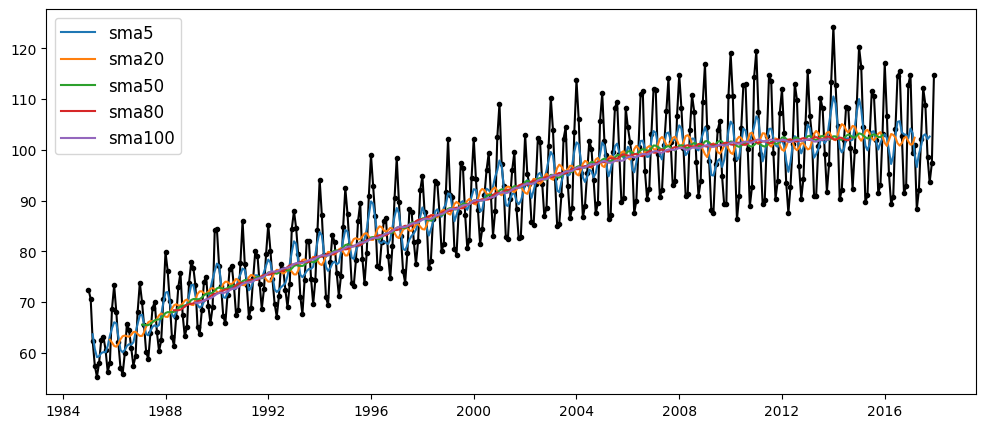

In [135]:
# Plot the curve for every record in some range
ini_date = '1985-01-01' # Only change months or years
end_date = '2017-12-01'

# Extract the data
idx_init = np.where(df['Date'] == ini_date)[0][0]
idx_end = np.where(df['Date'] == end_date)[0][0]
df_portion = df.loc[idx_init:idx_end, ['Date', 'IPG2211A2N']]

# Obtain some moving averages for smoothing
sma5 = df_portion['IPG2211A2N'].rolling(window = 5, center=True).mean()
sma20 = df_portion['IPG2211A2N'].rolling(window = 20, center=True).mean()
sma50 = df_portion['IPG2211A2N'].rolling(window = 50, center=True).mean()
sma80 = df_portion['IPG2211A2N'].rolling(window = 80, center=True).mean()
sma100 = df_portion['IPG2211A2N'].rolling(window = 100, center=True).mean()

# Show the values evolution in time
fig, ax = plt.subplots(figsize = (12, 5))
ax.plot(df_portion['Date'], df_portion['IPG2211A2N'], 'k.-')
ax.plot(df_portion['Date'], sma5, '-', label = 'sma5')
ax.plot(df_portion['Date'], sma20, '-', label = 'sma20')
ax.plot(df_portion['Date'], sma50, '-', label = 'sma50')
ax.plot(df_portion['Date'], sma80, '-', label = 'sma80')
ax.plot(df_portion['Date'], sma100, '-', label = 'sma100')

ax.legend(fontsize = 12)

plt.show()

In [136]:
# Define the features and target for a model predictor
X = np.arange(len(df_portion.index)).reshape(-1, 1)
y = df_portion['IPG2211A2N'].values

# Try a linear regression for the trend
linear_model = LinearRegression()
linear_model.fit(X, y)
linear_pred = linear_model.predict(X)

In [137]:
# Create a cuadratic model using deterministic process
dp_quadratic = DeterministicProcess(index = df_portion.index, order = 2, drop = True)
X_in = dp_quadratic.in_sample()

# Create features for a 50-month forecast.
X_out = dp_quadratic.out_of_sample(steps = 50)

X_in.tail()

,trend,trend_squared
391,392.0,153664.0
392,393.0,154449.0
393,394.0,155236.0
394,395.0,156025.0
395,396.0,156816.0


In [138]:
X_out.head()

,trend,trend_squared
396,397.0,157609.0
397,398.0,158404.0
398,399.0,159201.0
399,400.0,160000.0
400,401.0,160801.0


In [139]:
# Create a new predictor
model_quadratic = LinearRegression()
model_quadratic.fit(X_in, y)
pred_quadratic = model_quadratic.predict(X_in)

# Create a forecast prediction
fore_pred_quadratic = model_quadratic.predict(X_out)

In [140]:
# Create a cubic model deterministic process
dp = DeterministicProcess(index = df_portion.index, order = 3, drop = True)
X_in = dp.in_sample()

# Create features for a 50-month forecast.
X_out = dp.out_of_sample(steps = 50)

X_in.tail()

,trend,trend_squared,trend_cubed
391,392.0,153664.0,60236288.0
392,393.0,154449.0,60698457.0
393,394.0,155236.0,61162984.0
394,395.0,156025.0,61629875.0
395,396.0,156816.0,62099136.0


In [141]:
X_out.head()

,trend,trend_squared,trend_cubed
396,397.0,157609.0,62570773.0
397,398.0,158404.0,63044792.0
398,399.0,159201.0,63521199.0
399,400.0,160000.0,64000000.0
400,401.0,160801.0,64481201.0


In [142]:
# Create a new predictor
model = LinearRegression()
model.fit(X_in, y)
pred = model.predict(X_in)

# Create a forecast prediction
fore_pred = model.predict(X_out)

In [143]:
# Check another (power-law) fit
def power_fit(x, *coefs):
    return coefs[0]*x**coefs[1] + coefs[2]

coefs = scop.curve_fit(power_fit, X.reshape(X.shape[0]), y, p0 = np.ones(3))
params, err_matrix = coefs

power_prediction = power_fit(X, *params)
coefs

(array([ 1.92833577,  0.55299337, 54.8871148 ]),
 array([[ 6.66618333e-01, -5.16235651e-02, -2.37152018e+00],
        [-5.16235651e-02,  4.01965909e-03,  1.79699079e-01],
        [-2.37152018e+00,  1.79699079e-01,  9.31515229e+00]]))

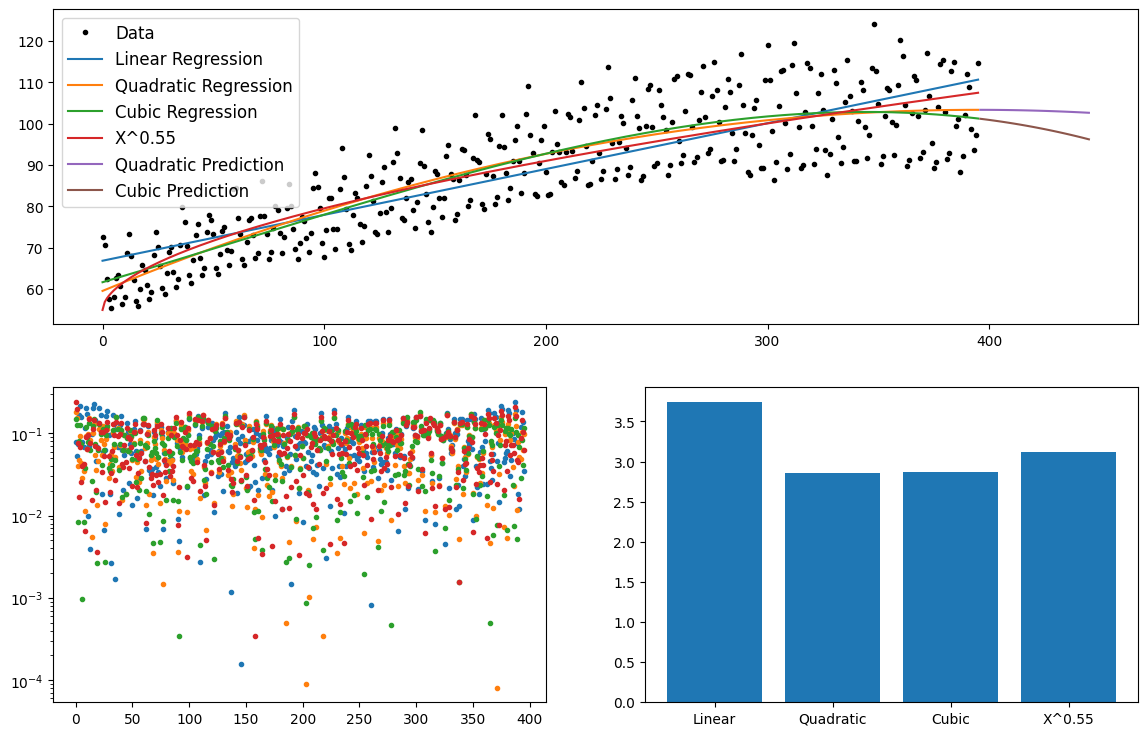

In [144]:
# Show the values evolution in time
fig = plt.figure(figsize = (14, 9))
ax1 = plt.subplot(211)
ax2 = plt.subplot(223)
ax3 = plt.subplot(224)

ax1.plot(X, y, 'k.', label = 'Data')
ax1.plot(X, linear_pred, '-', label = 'Linear Regression')
ax1.plot(X, pred_quadratic, '-', label = 'Quadratic Regression')
ax1.plot(X, pred, '-', label = 'Cubic Regression')
ax1.plot(X, power_prediction, '-', label = 'X^'+str(np.round(params[1], 2)))
ax1.plot(X_out.index, fore_pred_quadratic, '-', label = 'Quadratic Prediction')
ax1.plot(X_out.index, fore_pred, '-', label = 'Cubic Prediction')

ax2.plot(X, abs(y - linear_pred)/y, '.', label = 'Linear Regression')
ax2.plot(X, abs(y - pred_quadratic)/y, '.', label = 'Quadratic Regression')
ax2.plot(X, abs(y - pred)/y, '.', label = 'Cubic Regression')
ax2.plot(X, abs(y - power_prediction.flatten())/y, '.', label = 'X^'+str(np.round(params[1], 2)))

labels = ['Linear', 'Quadratic', 'Cubic', 'X^'+str(np.round(params[1], 2))]
errors = [np.sum((y - linear_pred)/y), np.sum((y - pred_quadratic)/y), 
          np.sum((y - pred)/y), np.sum((y - power_prediction.flatten())/y)]

ax3.bar(labels, np.abs(errors))

ax2.set_yscale('log')
ax1.legend(fontsize = 12)

plt.show()

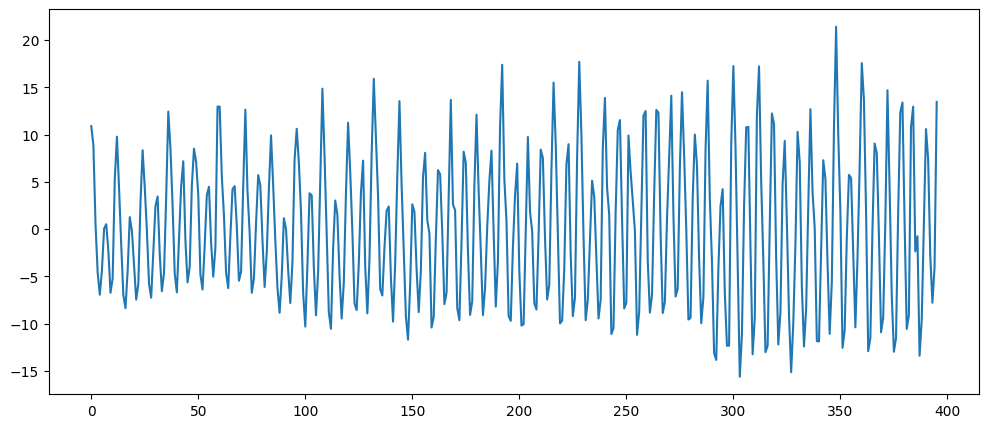

In [145]:
fig, ax = plt.subplots(figsize = (12, 5))

ax.plot(X, y - pred)

plt.show()

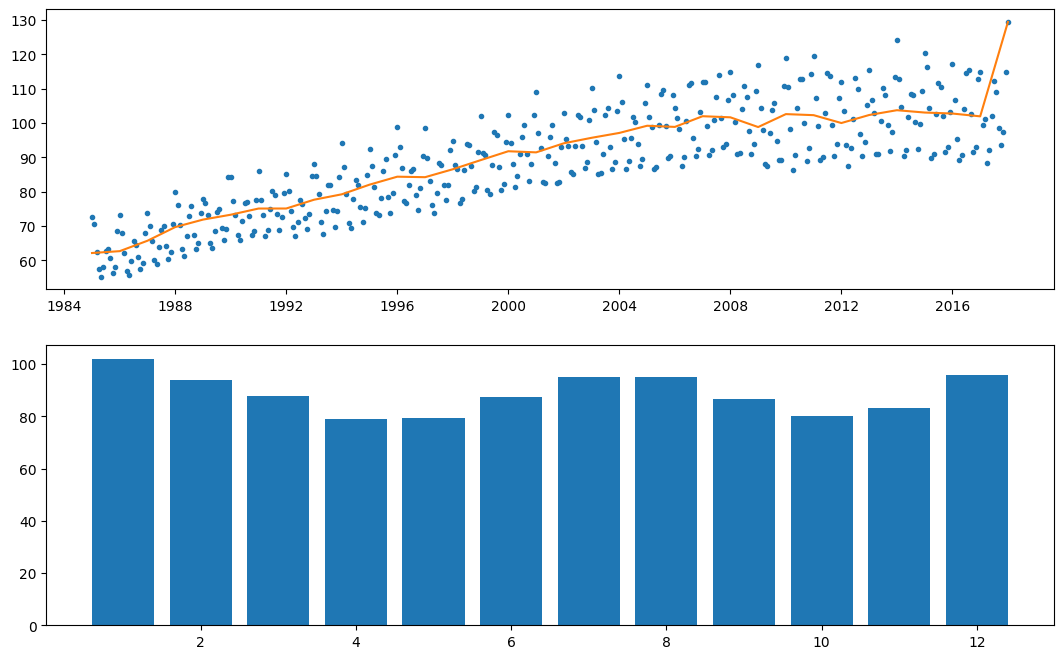

In [146]:
# Find the trend by months and years
df_year = df[['Year', 'IPG2211A2N']].groupby('Year', as_index = False).mean()
df_month = df[['Month', 'IPG2211A2N']].groupby('Month', as_index = False).mean()

fig, ax = plt.subplots(nrows = 2, ncols = 1, figsize = (13, 8))

# Respect the format
ax[0].plot(df['Date'], df['IPG2211A2N'], '.')
ax[0].plot(pd.to_datetime(df_year['Year'].astype(str)+'-01-01'), df_year['IPG2211A2N'], '-')
ax[1].bar(df_month['Month'], df_month['IPG2211A2N'])

plt.show()

## [LagPlots](https://www.statisticshowto.com/lag-plot/)

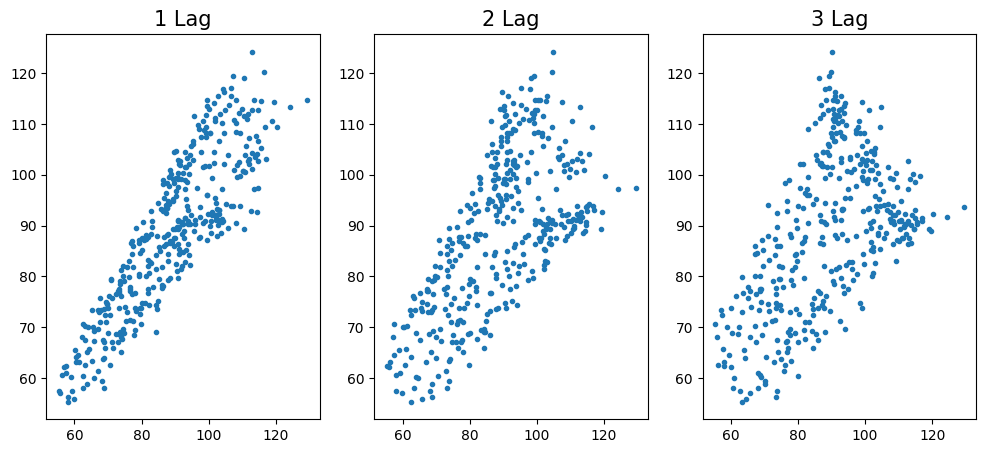

In [147]:
X = df[['IPG2211A2N']]

lag_1 = X.shift(1)
lag_2 = X.shift(2)
lag_3 = X.shift(3)

fig, axs = plt.subplots(nrows = 1, ncols = 3, figsize = (12, 5))
axs[0].plot(X, lag_1, '.')
axs[1].plot(X, lag_2, '.')
axs[2].plot(X, lag_3, '.')

axs[0].set_title('1 Lag', fontsize = 15)
axs[1].set_title('2 Lag', fontsize = 15)
axs[2].set_title('3 Lag', fontsize = 15)

plt.show()

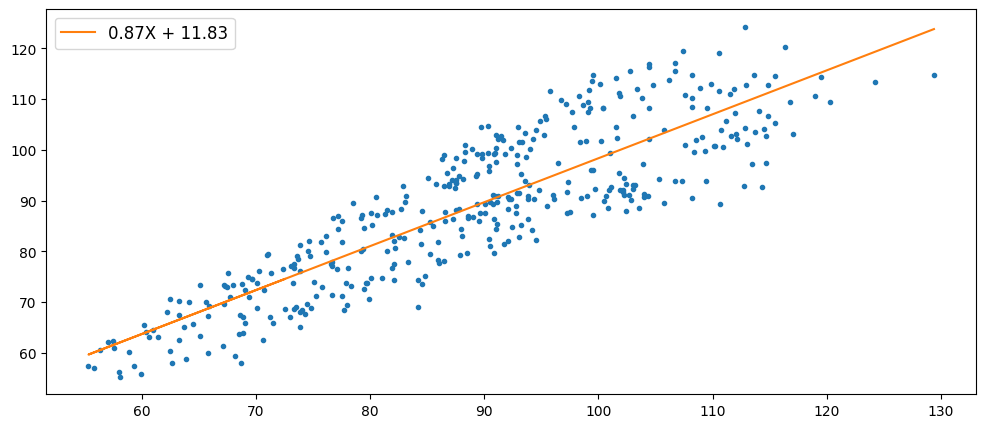

In [148]:
lag_model = LinearRegression()
lag_model.fit(X[1:], lag_1[1:])
lag_pred = lag_model.predict(X)

p1, p2 = np.round(lag_model.coef_[0][0], 2), np.round(lag_model.intercept_[0], 2)

fig, axs = plt.subplots(figsize = (12, 5))
axs.plot(X, lag_1, '.')
axs.plot(X, lag_pred, '-', label = str(p1)+'X + '+str(p2))

axs.legend(fontsize = 12)

plt.show()

## Seasonality

In [149]:
def seasonal_plot(df, season='year', index='month', column=None):
    """
    - df: (Pandas) DataFrame indexed by Datetime
    - season (string): the season that you want to considering when doing the plot, e.g., year, month, etc.;
    - index (string): corresponds to the x-axis of the plot. You should choose based on the index period that you're using;
    - column (string, optional): the DataFrame column to consider. Picks the first one by default.
    """
    if column == None:
        column = df.columns[0]
    
    piv_index = getattr(df.index, index)
    piv_season = getattr(df.index, season)
    
    piv = pd.pivot_table(df, index = piv_index, columns = piv_season, values = column)
    ax = piv.plot(figsize = (14, 5))
    ax.legend(loc = 'upper left', bbox_to_anchor = (1, 1), ncol = 2)

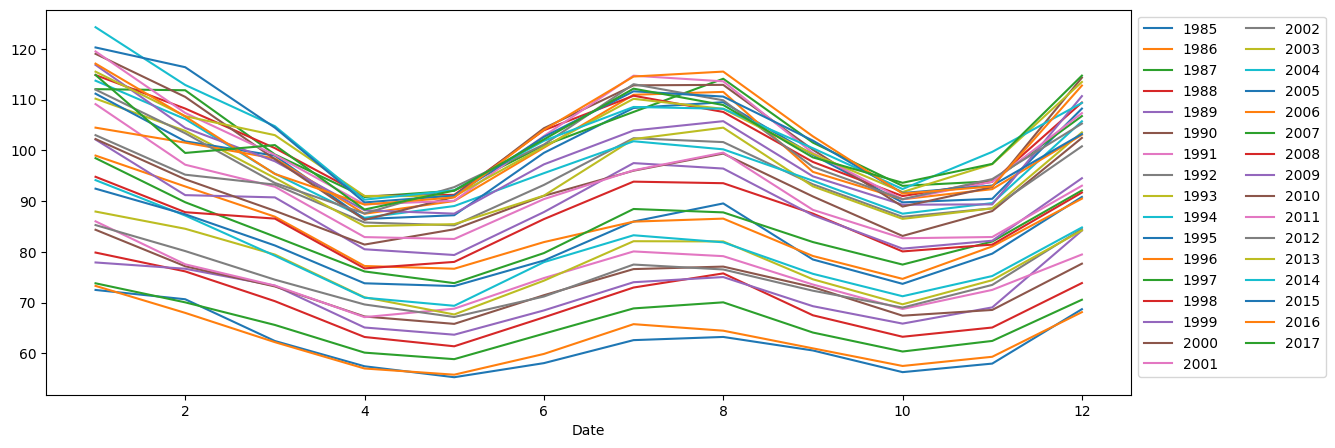

In [150]:
seasonal_plot(df_portion.set_index(['Date']))

In [151]:
def periodogram_plot(N, y, y_trend = np.array([]), T = 1):
    x = np.arange(T, (N+1)*T, T)

    if len(y_trend) == 0:
        y_trend = np.zeros(N)
    yf = fft(y - y_trend)
    xf = fftfreq(N, T)[:N//2]
    
    fig, ax = plt.subplots(figsize = (12, 5))
    ax.plot(xf, 2/N*np.abs(yf[:N//2])**2)

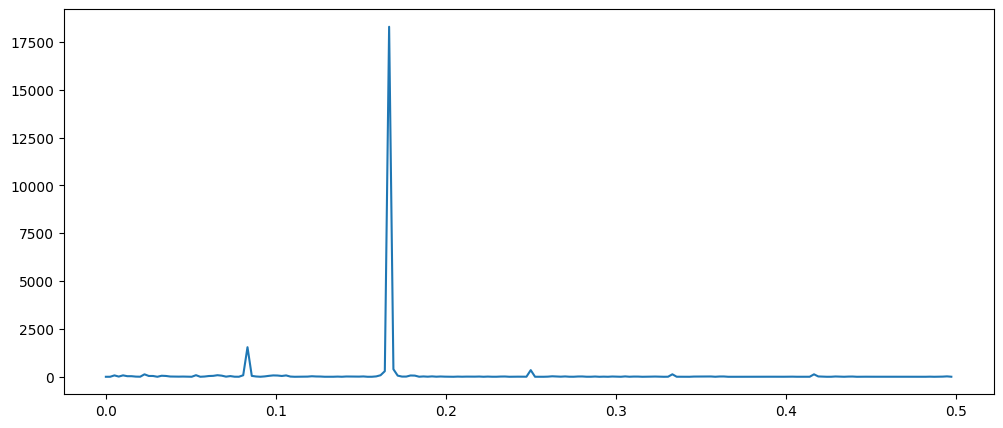

In [152]:
# Number of sample points (days, months, years...)
N = len(df_portion['Date'].dt.day_of_year.values)

# Standard frequencies
# Anually = 1/12 = 0.083
# Semestral = 1/6 = 0.167
# Trimestal = 1/3 = 0.333
# Bimontlhy = 1/2 = 0.5

periodogram_plot(N, y, pred)

In [153]:
fourier = CalendarFourier(freq = 'YE', order = 2)

dp = DeterministicProcess(index=df_portion.set_index('Date').index, constant = True, order = 2, seasonal = False, 
                          additional_terms = [fourier], drop=True)

# Generate the features for the trend and seasonality
X = dp.in_sample()

# Fit a linear regression model to the data
model = LinearRegression().fit(X, y)

# Predict the trend and seasonality
y_pred = model.predict(X)

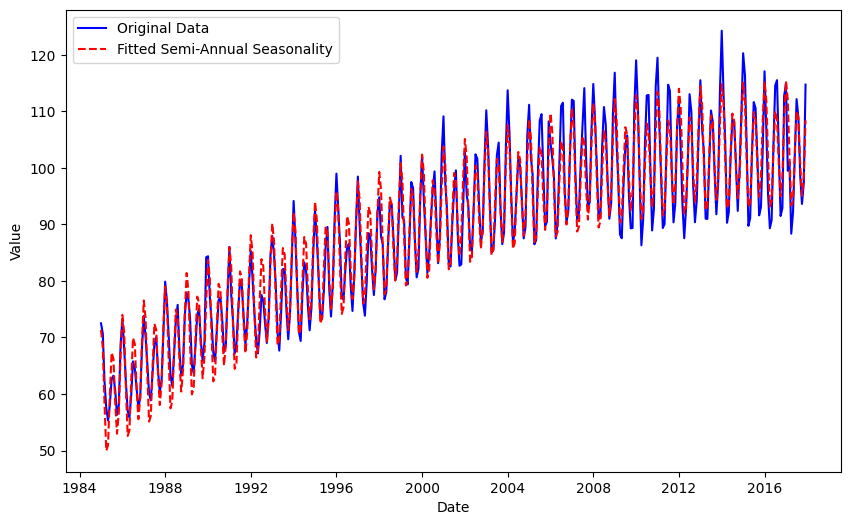

In [154]:
plt.figure(figsize=(10, 6))
plt.plot(df_portion.set_index('Date').index, y, label="Original Data", color="blue")
plt.plot(df_portion.set_index('Date').index, y_pred, label="Fitted Semi-Annual Seasonality", linestyle="--", color="red")
plt.xlabel("Date")
plt.ylabel("Value")
plt.legend()
plt.show()

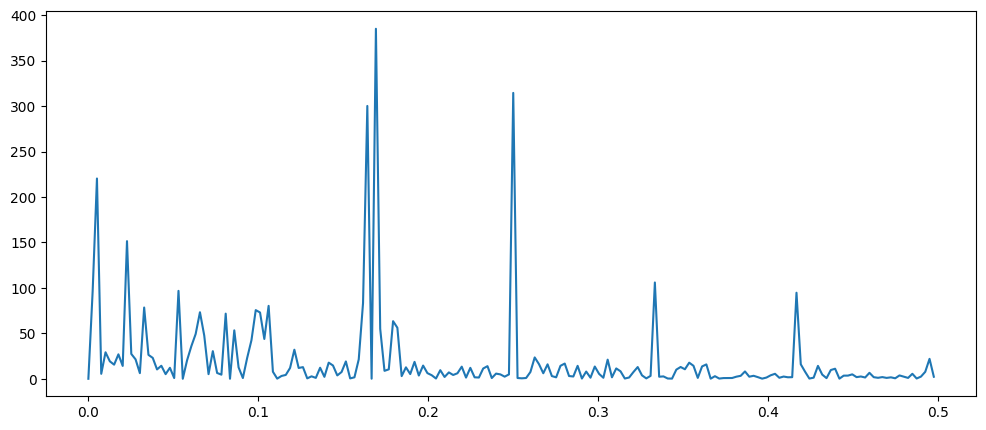

In [155]:
# Check that we have erased all seasonality
periodogram_plot(N, y - y_pred)

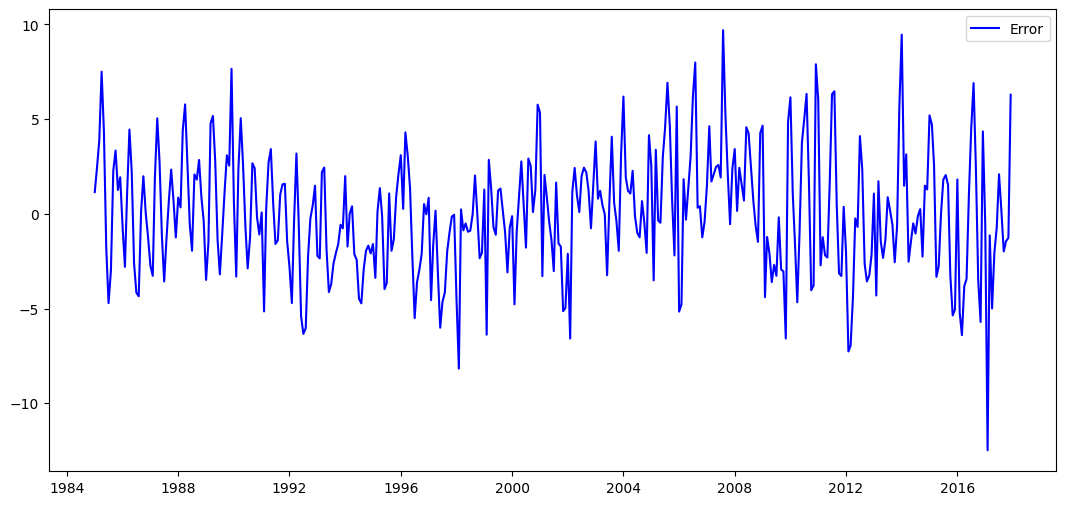

In [156]:
plt.figure(figsize=(13, 6))
plt.plot(df_portion.set_index('Date').index, y - y_pred, label = 'Error', color = 'blue')
plt.legend()

plt.show()

## Cycles

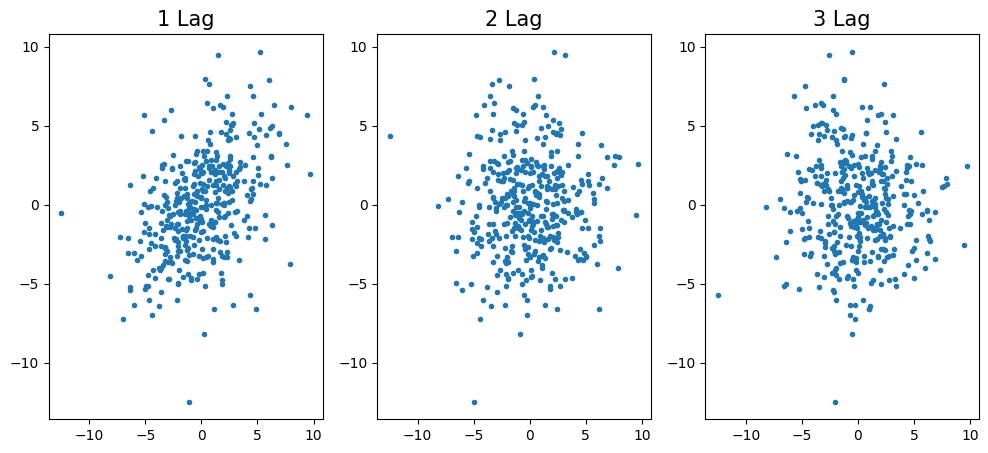

In [157]:
# Check the lagplots with the deseasonalized values
X = pd.Series(y - y_pred)

lag_1 = X.shift(1)
lag_2 = X.shift(2)
lag_3 = X.shift(3)

fig, axs = plt.subplots(nrows = 1, ncols = 3, figsize = (12, 5))
axs[0].plot(X, lag_1, '.')
axs[1].plot(X, lag_2, '.')
axs[2].plot(X, lag_3, '.')

axs[0].set_title('1 Lag', fontsize = 15)
axs[1].set_title('2 Lag', fontsize = 15)
axs[2].set_title('3 Lag', fontsize = 15)

plt.show()